<a href="https://colab.research.google.com/github/Anil951/Early-detection-of-mental-health/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

import re
import string
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df=pd.read_csv("/content/clean.csv")
df

,label,c_text3
0,0,dear american teen question dutch person heard...
1,1,nothing look forward lifei dont many reason ke...
2,0,music recommendation im looking expand playlis...
3,1,im done trying feel betterthe reason im still ...
4,1,worried year old girl subject domestic physica...
...,...,...
27967,0,posting everyday people stop caring religion m...
27968,0,okay definetly need hear guy opinion ive prett...
27969,1,cant get dog think ill kill myselfthe last thi...
27970,1,whats point princess bridei really think like ...


In [5]:
data = {
    'Label': ["Non-mental-health", "Mental-health"],
    'Label Encoded': [0,1]
}

dr = pd.DataFrame(data)
dr

,Label,Label Encoded
0,Non-mental-health,0
1,Mental-health,1


In [6]:
class_names=dr.Label.to_list()
class_names

['Non-mental-health', 'Mental-health']

In [14]:
print('total size: ', df.shape[0])

# Do we have duplicates?
print(' Duplicates:', len(df[df.duplicated()]))

# Do we have missing values?
missing_values = df.isnull().sum()
print('Missing Values by column:\n',missing_values)

print('Missing Values:', df.isnull().sum().sum())

total size:  27972
 Duplicates: 1
Missing Values by column:
 label      0
c_text3    2
dtype: int64
Missing Values: 2


In [15]:
df.replace("", np.nan, inplace=True)
missing_values = df.isnull().sum()
print('Missing Values and Empty Spaces by column:\n',missing_values)

Missing Values and Empty Spaces by column:
 label      0
c_text3    2
dtype: int64


In [16]:
duplicate_rows = df[df.duplicated(keep=False)]

# Then sort the dataframe on all columns to ensure duplicates are adjacent
sorted_duplicates = duplicate_rows.sort_values(by=list(duplicate_rows.columns))

# Now, if we want to see 5 pairs of duplicates (10 rows), we can simply:
top_5_duplicate_pairs = sorted_duplicates.head(20)

top_5_duplicate_pairs

,label,c_text3
229,0,day asking day day people woke great day
21705,0,day asking day day people woke great day


In [17]:
df = df.drop_duplicates()
print('Duplicates:', len(df[df.duplicated()]))

Duplicates: 0


In [18]:
df = df.dropna()
print('Missing Values:', df.isnull().sum().sum())

Missing Values: 0


In [19]:
X = df['c_text3'].to_numpy()
y = df['label'].to_numpy()

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((25172,), (2797,), (25172,), (2797,))

In [22]:
text_lengths = [len(str(text).split()) for text in X_train]

# Find the 95th percentile
percentile_95 = np.percentile(text_lengths, 95)

print(f"95th Percentile of Text Lengths: {percentile_95}")

95th Percentile of Text Lengths: 231.0


In [23]:
max_text_length = max(text_lengths)
print(f"Maximum Text Length: {max_text_length}")

Maximum Text Length: 2556


In [24]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length = None  # max number of words to have in our vocabulary
max_length = int(percentile_95)  # max length our sequences will be (e.g. how many words from a text does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [25]:
text_vectorizer.adapt(X_train)

In [26]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 62781
Top 5 most common words: ['', '[UNK]', 'im', 'like', 'want']
Bottom 5 least common words: ['aaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaa']


In [27]:
max_vocab_length=len(words_in_vocab)

# ***pipeline model***

In [28]:
# Naive Bayes tends to perform well because it relies on probability distributions
# rather than complex optimization processes like other classifiers (e.g., SVMs or neural networks).

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Now fit the model
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [40]:
import pickle

with open('model_nb.pkl', 'wb') as f:
    pickle.dump(model_0, f)

print("model saved as ",f)

model saved as  <_io.BufferedWriter name='model_nb.pkl'>


In [29]:
baseline_score = model_0.score(X_valid, y_valid)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 85.13%


In [30]:
baseline_preds = model_0.predict(X_valid)
baseline_preds[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

baseline_results = calculate_results(y_true=y_valid, y_pred=baseline_preds)
baseline_results

{'accuracy': 85.12692170182338,
 'precision': 0.8776854575982233,
 'recall': 0.8512692170182338,
 'f1': 0.8488621374386252}

In [64]:
import pickle
import pandas as pd

# Load the model using pickle
with open('model_nb.pkl', 'rb') as f:
    model_0_loaded = pickle.load(f)

# Use the loaded model to predict new sentences
new_sentences = ["She's been very depressed and upset about this whole situation"]
predictions = model_0_loaded.predict(new_sentences)

if(predictions==0):
  print("0 - Non-mental-health")
else:
  print("1 - Mental-health")

1 - Mental-health


# ***dense model***

In [32]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [33]:
# embedding layer in a neural network, commonly used in NLP tasks.
# The layers.Embedding layer is specifically designed to convert words or tokens into dense, continuous-valued vectors
# (called embeddings) that represent their semantic meaning.

tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=300, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [34]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_dense = tf.keras.Model(inputs, outputs, name="model_dense") # construct the model

In [35]:
model_dense.summary()

Model: "model_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 231)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 231, 300)            │      18,834,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             301 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,834,601 (71.85 MB)

 Trainable params: 18,834,601 (71.85 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model_dense.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [43]:
model_dense_history = model_dense.fit(X_train, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              epochs=10,
                              validation_data=(X_valid, y_valid),)

Epoch 1/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 278s 351ms/step - accuracy: 0.7232 - loss: 0.5392 - val_accuracy: 0.8845 - val_loss: 0.3197
Epoch 2/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 299s 322ms/step - accuracy: 0.8730 - loss: 0.3107 - val_accuracy: 0.8867 - val_loss: 0.2754
Epoch 3/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 259s 318ms/step - accuracy: 0.8974 - loss: 0.2570 - val_accuracy: 0.9042 - val_loss: 0.2584
Epoch 4/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 268s 326ms/step - accuracy: 0.9098 - loss: 0.2295 - val_accuracy: 0.9106 - val_loss: 0.2506
Epoch 5/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 259s 322ms/step - accuracy: 0.9171 - loss: 0.2114 - val_accuracy: 0.9181 - val_loss: 0.2484
Epoch 6/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 259s 318ms/step - accuracy: 0.9244 - loss: 0.1975 - val_accuracy: 0.9188 - val_loss: 0.2501
Epoch 7/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 265s 322ms/step - accuracy: 0.9306 - loss: 0.1866 - val_accuracy: 0.9206 - val_loss: 0.2551
Epoch 8/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 258s 317ms/step - accuracy: 0.9344 -

In [69]:
import pickle

text_vectorizer.adapt(X_train)

# Get the vectorizer configuration and weights
vectorizer_config = text_vectorizer.get_config()
vectorizer_weights = text_vectorizer.get_weights()

# Save the config and weights as a tuple
with open("text_vectorizer.pkl", "wb") as f:
    pickle.dump((vectorizer_config, vectorizer_weights), f)

In [48]:
model_dense.evaluate(X_valid, y_valid)

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8945 - loss: 0.3339


[0.29673081636428833, 0.900250256061554]

In [49]:
model_dense_pred_probs = model_dense.predict(X_valid)
model_dense_pred_probs[:10]

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


array([[0.986857  ],
       [0.5816667 ],
       [0.9777785 ],
       [0.99999666],
       [0.9984303 ],
       [0.03459587],
       [0.15774393],
       [0.8452648 ],
       [0.3946647 ],
       [0.22247191]], dtype=float32)

In [50]:
model_dense_preds = tf.squeeze(tf.round(model_dense_pred_probs))
model_dense_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 0., 0., 1., 0., 0.], dtype=float32)>

In [51]:
model_dense_results = calculate_results(y_true=y_valid,
                                    y_pred=model_dense_preds)
model_dense_results

{'accuracy': 90.02502681444405,
 'precision': 0.905464874180341,
 'recall': 0.9002502681444404,
 'f1': 0.8999934965873262}

In [103]:
y_true = y_valid.tolist()  # Convert labels to a list
preds = model_dense.predict(X_valid)
y_probs = preds.squeeze().tolist()  # Store the prediction probabilities as a list
y_preds = tf.round(y_probs).numpy().tolist()

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [104]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [53]:
class_names

['Non-mental-health', 'Mental-health']

In [57]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

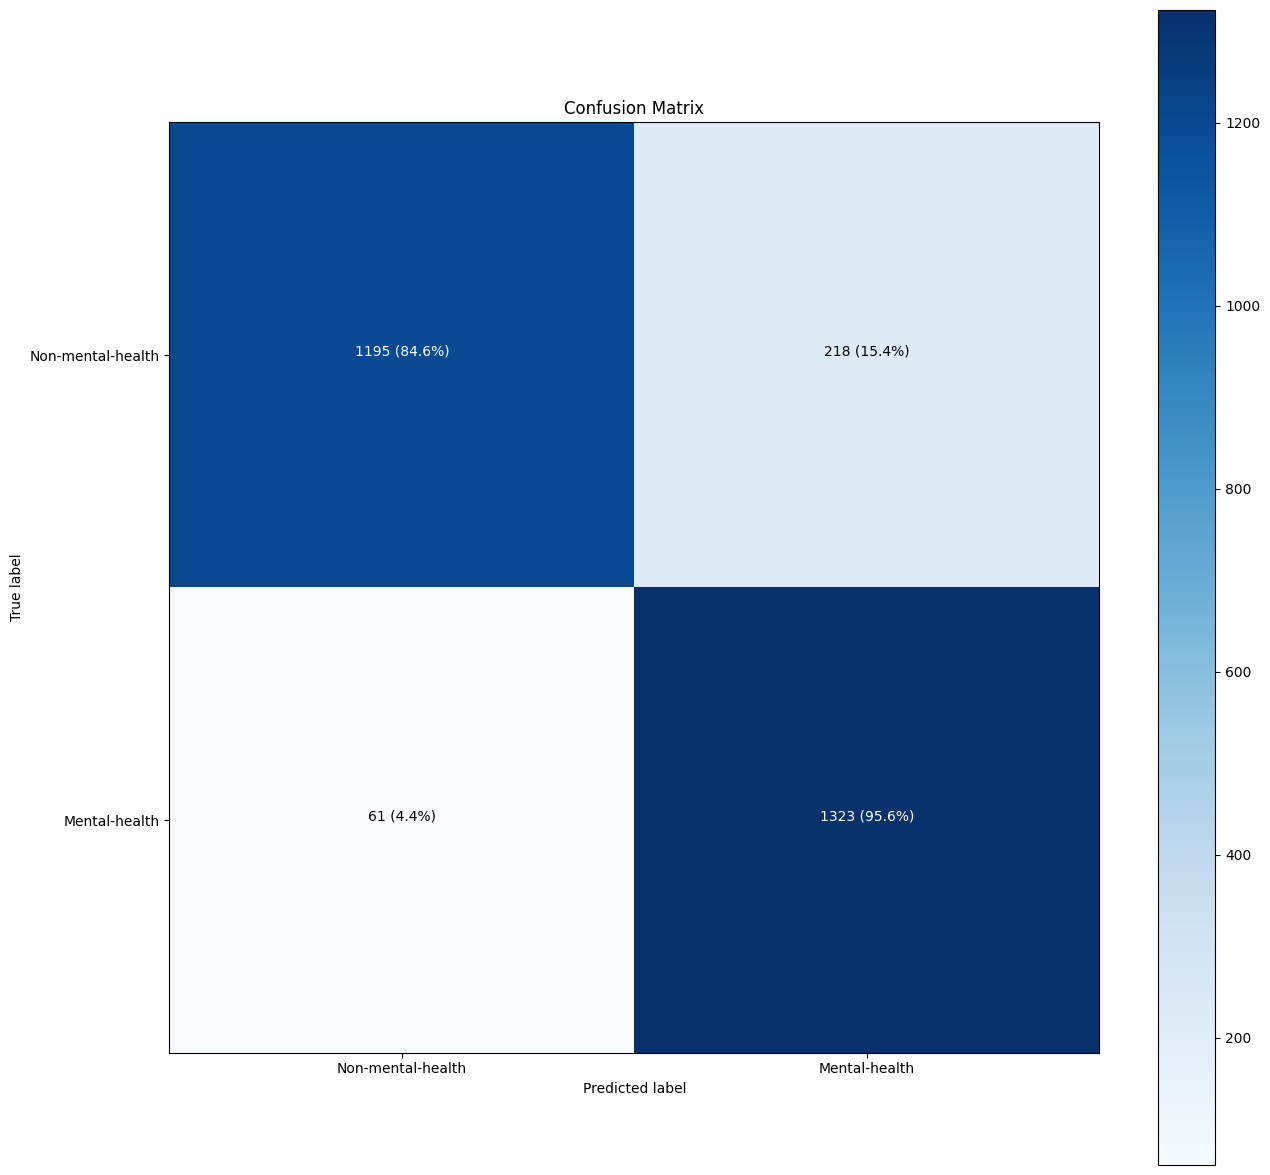

In [58]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

# 1195: True Negatives (TN) — The model correctly predicted Non-mental-health for 1195 instances.
# 218: False Positives (FP) — The model incorrectly predicted Mental-health for 218 instances that were actually Non-mental-health.
# 61: False Negatives (FN) — The model incorrectly predicted Non-mental-health for 61 instances that were actually Mental-health.
# 1323: True Positives (TP) — The model correctly predicted Mental-health for 1323 instances.

In [59]:
!pip install colorama
from colorama import Fore, Style
import numpy as np

def random_predictions(model, X_valid, y_valid, num_samples=5, class_names=None):
    # Check if it's binary or multi-class classification
    is_binary_classification = len(np.unique(y_valid)) == 2

    # Getting indices of the random samples
    random_indices = np.random.choice(np.arange(len(X_valid)), size=num_samples, replace=False)

    # Selecting the random samples
    random_X_samples = X_valid[random_indices]
    random_y_samples = y_valid[random_indices]
    # Making predictions on the random samples
    y_pred_probs = model.predict(random_X_samples)

    if is_binary_classification:
        y_pred = np.squeeze(np.round(y_pred_probs).astype(int))
    else:
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Print the actual and predicted labels
    for i in range(num_samples):
        text = random_X_samples[i]
        true_label = random_y_samples[i] if is_binary_classification else np.argmax(random_y_samples[i])
        predicted_label = y_pred[i]
        # If class names are provided, use them for printing
        if class_names is not None:
            true_label_name = class_names[true_label]
            predicted_label_name = class_names[predicted_label]
        else:
            true_label_name = true_label
            predicted_label_name = predicted_label

        # Determine the color of the text (green for correct, red for incorrect)
        text_color = Fore.GREEN if true_label == predicted_label else Fore.RED

        print(f"\nSample {i + 1}:")
        print(f"Text: {text}")
        print(text_color + f"True: {true_label_name} \n Predicted: {predicted_label_name}" + Style.RESET_ALL)

In [63]:
random_predictions(model_dense,
                   X_valid,
                   y_valid,
                   num_samples=10,
                   class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Sample 1:
Text: career chose process making rich also extremely depressed overworkedoverjudged point least one episode day want curl disappear job involves social medium fame expectation perfection sometimes sure much handle human break able make real friend family never begin relationship someone cared pursuit wellbeing people respect name almost daily disrespect person make sense people always watching extremely careful almost feel like redflag now people around want something also constantly comparing body next best thing type industry mentally draining wish fame anyonei wanted see anyone advice going therapy still super depressive episode lot regret pursuing loved much everything sacrifice success word advice successful depressed
True: Mental-health 
 Predicted: Mental-health

Sample 2:
Text: glad valentine day really like holiday couple love ive never able relate kind sad day im happy got spend someone specially case made sad im glad thats ov

# ***lstm***

In [108]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_1LSTM_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=300,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_1LSTM_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the text (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_LSTM = tf.keras.Model(inputs, outputs, name="model_1LSTM")

(None, 100, 300)
(None, 64)


In [109]:
model_LSTM.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [110]:
model_LSTM.summary()

Model: "model_1LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_3                 │ (None, 100)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 100, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 64)             │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,130,689 (11.94 MB)

 Trainable params: 3,130,689 (11.94 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
model_LSTM_history = model_LSTM.fit(X_train, y_train,
                              epochs=10,
                              validation_data=(X_valid, y_valid),)

Epoch 1/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 316s 261ms/step - accuracy: 0.7555 - loss: 0.4838 - val_accuracy: 0.9103 - val_loss: 0.2279
Epoch 2/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 252s 249ms/step - accuracy: 0.9317 - loss: 0.1900 - val_accuracy: 0.9099 - val_loss: 0.2288
Epoch 3/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 191s 243ms/step - accuracy: 0.9547 - loss: 0.1306 - val_accuracy: 0.9067 - val_loss: 0.2666
Epoch 4/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 179s 227ms/step - accuracy: 0.9697 - loss: 0.0902 - val_accuracy: 0.9135 - val_loss: 0.3012
Epoch 5/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 203s 229ms/step - accuracy: 0.9769 - loss: 0.0712 - val_accuracy: 0.9113 - val_loss: 0.3033
Epoch 6/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 200s 226ms/step - accuracy: 0.9815 - loss: 0.0549 - val_accuracy: 0.9067 - val_loss: 0.3472
Epoch 7/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 204s 230ms/step - accuracy: 0.9882 - loss: 0.0378 - val_accuracy: 0.9131 - val_loss: 0.3445
Epoch 8/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 208s 237ms/step - accuracy: 0.9907 -

In [112]:
model_LSTM.evaluate(X_valid, y_valid)

88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9147 - loss: 0.4260


[0.44439882040023804, 0.9088308811187744]

In [113]:
model_LSTM_pred_probs = model_LSTM.predict(X_valid)
model_LSTM_pred_probs.shape, model_LSTM_pred_probs[:10]

88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step


((2797, 1),
 array([[9.9698228e-01],
        [2.0925628e-03],
        [9.9688494e-01],
        [9.9725360e-01],
        [9.9652076e-01],
        [7.5133961e-01],
        [5.3763986e-03],
        [9.4419885e-01],
        [9.9305242e-01],
        [8.7692359e-05]], dtype=float32))

In [114]:
model_LSTM_preds = tf.squeeze(tf.round(model_LSTM_pred_probs))
model_LSTM_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 1., 1., 1., 0., 1., 1., 0.], dtype=float32)>

In [115]:
model_LSTM_results = calculate_results(y_true=y_valid,
                                    y_pred=model_LSTM_preds)
model_LSTM_results

{'accuracy': 90.88308902395423,
 'precision': 0.9088304233041032,
 'recall': 0.9088308902395423,
 'f1': 0.9088305405891652}

In [116]:
y_true = y_valid.tolist()  # Convert labels to a list
preds = model_LSTM.predict(X_valid)
y_probs = preds.squeeze().tolist()  # Store the prediction probabilities as a list
y_preds = tf.round(y_probs).numpy().tolist()

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step


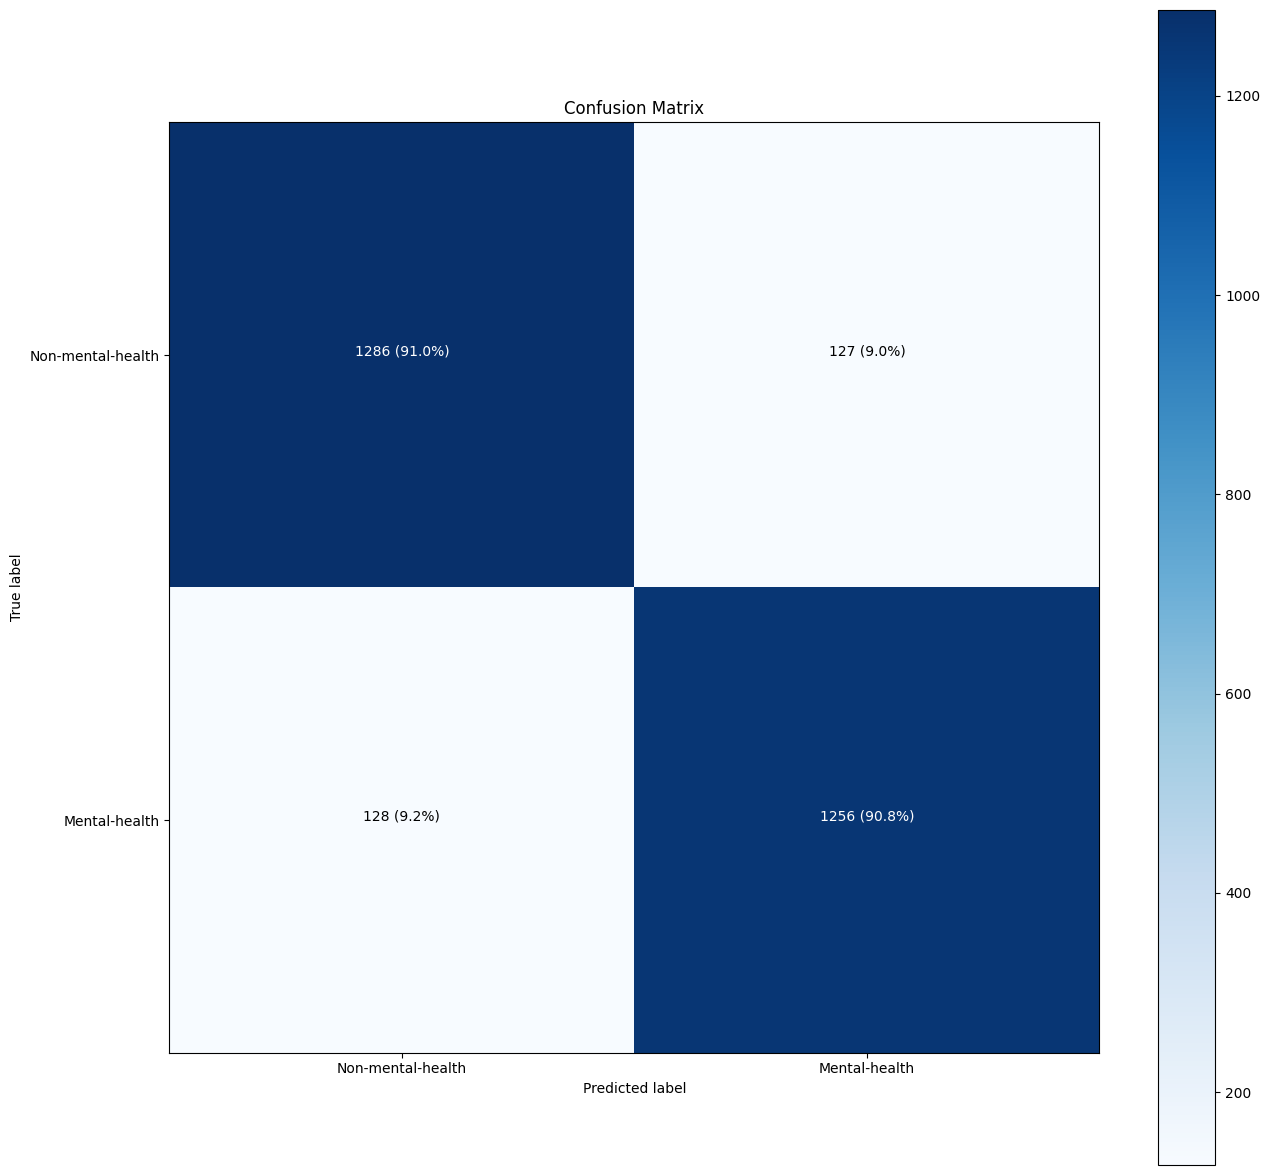

In [117]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

In [118]:
random_predictions(model_LSTM,
                   X_valid,
                   y_valid,
                   num_samples=20,
                   class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Sample 1:
Text: im going kill needed relese iner pain somwhereim going kill tonight thought present like cancer spinning around mind end present im tired everything call life walk hell knowing thing get worse nothing get better know big piece shit deserves world made suffering im tired bad emotion come hard handle everything want turn nightmare keep asking wrong life say think death much used drug stopped already two year made open later prelude accepting mistake yah say get work earn money understand much take care person barely move pour salt meal worked year trying fix problem spend money saving someone life spend dam even started live buddhist monk who sleep floor empty room without material possession life moving anywhere cant anything really help heal dad feel like shit hard take care think gon na ower hate im week mind hurt nobady help fuck nothing others help feel like prison opportunity thought run save life people meet walk door worry re

# ***comparing pipeline, dense, lstm models and ensembling***

In [120]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "Simple Dense": model_dense_results,
                                  "LSTM": model_LSTM_results,
                                  })

all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.851269,0.877685,0.851269,0.848862
Simple Dense,0.900250,0.905465,0.900250,0.899993
LSTM,0.908831,0.908830,0.908831,0.908831


In [121]:
all_model_results_sorted = all_model_results.sort_values("f1", ascending=False)
all_model_results_sorted

,accuracy,precision,recall,f1
LSTM,0.908831,0.908830,0.908831,0.908831
Simple Dense,0.900250,0.905465,0.900250,0.899993
baseline,0.851269,0.877685,0.851269,0.848862


In [123]:
combined_pred_probs =  tf.squeeze(model_dense_pred_probs, axis=1) + tf.squeeze(model_LSTM_pred_probs)
combined_preds = tf.round(combined_pred_probs/2) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 0., 0.], dtype=float32)>

In [124]:
ensemble_results = calculate_results(y_valid, combined_preds)
ensemble_results

{'accuracy': 91.63389345727565,
 'precision': 0.9163503199451426,
 'recall': 0.9163389345727565,
 'f1': 0.9163404104387038}

In [125]:
all_model_results.loc["ensemble_results"] = ensemble_results

In [126]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.851269,0.877685,0.851269,0.848862
Simple Dense,0.900250,0.905465,0.900250,0.899993
LSTM,0.908831,0.908830,0.908831,0.908831
ensemble_results,91.633893,0.916350,0.916339,0.916340
